In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.integrate import odeint

In [96]:

class Species:
    # initialize species, make it aware of parent reaction system
    def __init__(self, system, name):
        self.system = system
        self.name = name
        
        self.equation = "0"
        self.components = ["0"]
        self.dt = None
        
        self.generateFunction()
        
    def generateFunction(self):
        self.equation = 'lambda X, P: ' + " + ".join(self.components)
        self.dt = eval(self.equation)
        
            
class Model:
    def __init__(self):
        self.species = []
        self.parameters = []
        
    def getSpecies(self, name):
        for i, s in enumerate(self.species):
            if s.name == name:
                return s
        print("error: species " + name + " was not found")
        return None
    
    def indexSpecies(self, name):
        for i, s in enumerate(self.species):
            if s.name == name:
                return i
        print("error: species " + name + " was not found")
        return None
        
    def addSpecies(self, name):
        self.species.append(Species(self, name))
        
    def addReaction(self, reactants, stoichometry, k, kinetic_dependencies):

        
        self.parameters.append(k[0])
        parameter = "P[{}]".format(len(self.parameters)-1)

        
        species = ["X[{}]".format(self.indexSpecies(name)) for name in kinetic_dependencies]
        order = len(kinetic_dependencies)
        
        nth = " * " if order > 0 else ""
        v = parameter + nth +  "*".join(species)
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
            
    def addMichaelisReaction(self, reactants, stoichometry, k, kinetic_dependencies):
        self.parameters.append(k[0]) #k_cat
        self.parameters.append(k[1]) #K_m
        
        k_cat = "P[{}]".format(len(self.parameters)-2)
        K_m = "P[{}]".format(len(self.parameters)-1)
        
        species = ["X[{}]".format(self.indexSpecies(name)) for name in kinetic_dependencies]
        limiting_substrate = "X[{}]".format(self.indexSpecies(reactants[0]))
        
        v = k_cat + " * " + species[0] + " * " + limiting_substrate + " /(" + K_m + " + " +  limiting_substrate + ")"
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
        
    def dX(self, X,t, P):
        dX = [species.dt(X,P) for species in self.species]
        return dX
    
    def simulate(self,X0,duration):
        t = np.linspace(0,duration,1000)
        solution = odeint(self.dX,X0,t,args=(model.parameters,))

        for i, species in enumerate(self.species):
            plt.plot(t,solution[:,i],label=species.name)
        plt.legend()
        plt.show()

    
        
        

[2.0, 0.04] ['E']
parse stoichometric reactions
parse stoichometric reactions


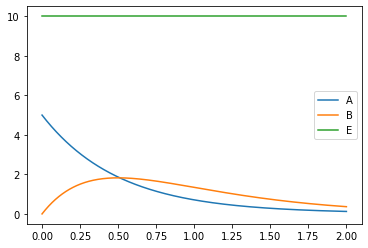

In [103]:
with open ("system.txt", "r") as myfile:
    data=myfile.readlines()
    
model = Model()

# read model from system definition
for i, line in enumerate(data):
    #remove newline and spaces
    line = line.strip("\n")
    line = line.replace(" ","")

    
    # match first line for species definition
    if i == 0:
        species_match = re.findall('[A-Z]+', line)
        if species_match:
            for species in species_match:
                model.addSpecies(species)
        else:
            print("error: no species found in first line of system definition")
    
    #match consecutive lines for reaction equations
    else:
        if len(line) > 0 and line[0] != "#":
            reaction_match = re.split("-.*->", line)
            reaction_definition = re.findall("-([A-Z])-(.*)->", line)[0]
            
            #match reaction constants and dependencies
            constants = re.findall("(\d*\.?\d+)", reaction_definition[1])

            if(len(constants) > 0):
                constants = [float(i) for i in constants]
                kinetic_dependencies = re.findall('[0-9]*[A-Z]+', reaction_definition[1])
                reaction_order = len(kinetic_dependencies)
  
            else: 
                 print("error: reaction constant was missing")
            
            #match products and educts
            if len(reaction_match) > 0:
                educts =  reaction_match[0]
                products = reaction_match[1]

                
                    
                educt_species = re.findall('[0-9]*[A-Z]+', educts)
                product_species = re.findall('[0-9]*[A-Z]+', products)


                reactants = []
                stoichometry = []

                for educt in educt_species:

                    s = re.findall('[0-9]+', educt)
                    N = 1 if len(s) == 0 else int(s[0])
                    name = re.findall('[A-Z]+', educt)[0]

                    if name in reactants:
                        stoichometry[reactants.index(name)] -= N
                    else:
                        reactants.append(name)
                        stoichometry.append(-N)

                for product in product_species:

                    s = re.findall('[0-9]+', product)
                    N = 1 if len(s) == 0 else int(s[0])
                    name = re.findall('[A-Z]+', product)[0]

                    if name in reactants:
                        stoichometry[reactants.index(name)] += N
                    else:
                        reactants.append(name)
                        stoichometry.append(N)
                        
                #stoichometric reaction        
                if reaction_definition[0] == "S":

                    model.addReaction(reactants,stoichometry,constants,educt_species)      
                
                #reaction with michaelis menten kinetics
                if reaction_definition[0] == "M":
                    
                    if len(educts) > 1:
                        print("warning: michaleis menten kinetic with more than one substrate specified. species " + educts[0] +" will be choosen as rate limiting.")
                        
                    model.addMichaelisReaction(reactants,stoichometry,constants,educt_species)      
                    print(constants,kinetic_dependencies)

                print("parse stoichometric reactions")
                
X0 = [5, 0, 10]
model.simulate(X0,2)